In [ ]:
import numpy as np
import cv2
import glob
import math
from skimage.exposure import rescale_intensity
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


import keras
from keras.layers import concatenate, Input, Dense
from keras.utils import to_categorical
from keras.models import Model
import numpy as np
import glob
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# cd drive/MyDrive/DIP/Project/

## **Utils**

In [ ]:
def convolution(img, kernel):
	(iHeight, iWidth) = img.shape[:2]
	(kHeight, kWidth) = kernel.shape[:2]
	padding = (kWidth - 1)//2
	img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
	output = np.zeros((iHeight, iWidth), dtype = 'float32')

	for y in np.arange(padding, iHeight + padding):
		for x in np.arange(padding, iWidth + padding):
			interest = img[y - padding : y + padding + 1, x - padding : x + padding + 1]
			k = (interest * kernel).sum()
			output[y - padding, x - padding] = k

	output = rescale_intensity(output, in_range = (0, 255))
	output = (output * 255).astype('uint8')

	return output

In [ ]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)
    
def sobel_edge_detection(image, filter, convert_to_degree=False, verbose=False):
    new_image_x = convolution1(image, filter, verbose)

    if verbose:
        plt.imshow(new_image_x, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

    new_image_y = convolution1(image, np.flip(filter.T, axis=0), verbose)

    if verbose:
        plt.imshow(new_image_y, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title("Gradient Magnitude")
        plt.show()

    gradient_direction = np.arctan2(new_image_y, new_image_x)

    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180

    return gradient_magnitude, gradient_direction
    

def convolution1(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))

    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image size : {}".format(output.shape))

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ( {}X{} )".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size), verbose=verbose)
    return convolution1(image, kernel, average=True, verbose=verbose)
    


def non_max_suppression(gradient_magnitude, gradient_direction, verbose=False):
    image_row, image_col = gradient_magnitude.shape

    output = np.zeros(gradient_magnitude.shape)

    PI = 180

    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]

            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]

            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]

            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]

            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]

            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()

    return output


def threshold(image, low, high, weak, verbose=False):
    output = np.zeros(image.shape)

    strong = 255

    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()

    return output


def hysteresis(image, weak):
    image_row, image_col = image.shape

    top_to_bottom = image.copy()

    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right

    final_image[final_image > 255] = 255

    return final_image

In [ ]:
def rotate_bound(image,angle):
    (h,w) = image.shape[:2]
    (cx,cy) = (w/2,h/2)

    M = cv2.getRotationMatrix2D((cx,cy),-angle,1.0)

    cos = np.abs(M[0,0])
    sin = np.abs(M[0,1])

    nW = int((h*sin)+(w*cos))
    nH = int((h*cos)+(w*sin))

    M[0,2] += (nW/2) - cx
    M[1,2] += (nH/2) - cy

    return cv2.warpAffine(image,M,(nW,nH))

In [ ]:
prewittX = np.array((
	[-1, 0, 1],
	[-1, 0, 1],
	[-1, 0, 1]), dtype="int")

prewittY = np.array((
	[-1, -1, -1],
	[0, 0, 0],
	[1, 1, 1]), dtype="int")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

laplacian = np.array((
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
))

LOG = np.array((
    [0, 0, 1, 0, 0],
    [0, 1, 2, 1, 0],
    [1, 2, -16, 2, 1],
    [0, 1, 2, 1, 0],
    [0, 0, 1, 0, 1]
))


## **Feature Generation**

0


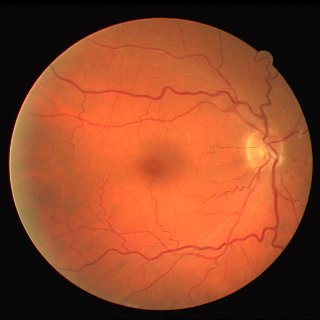

Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)
Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)
Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)


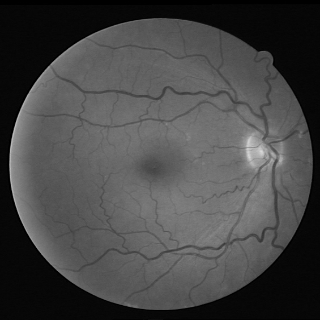

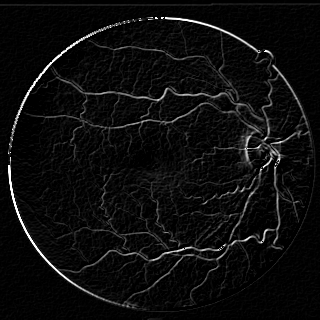

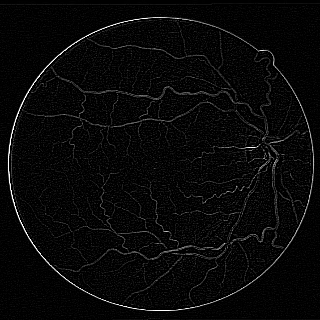

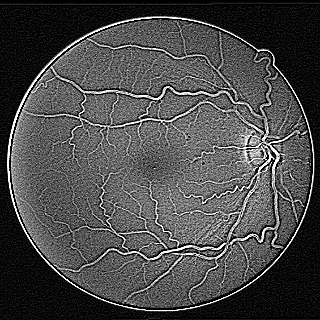

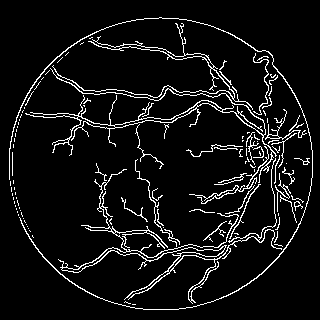

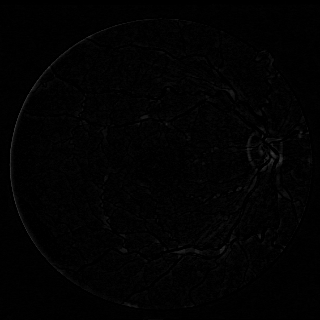

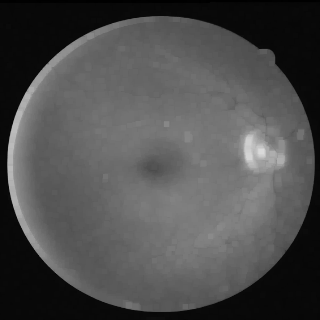

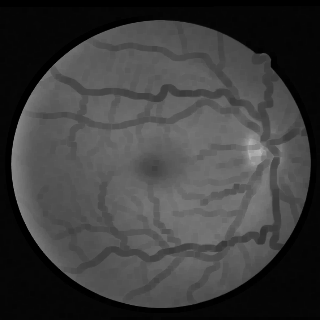

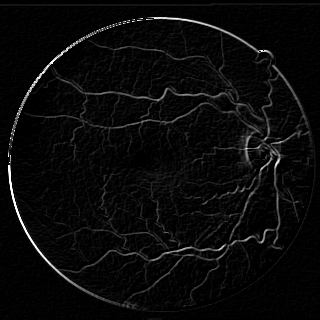

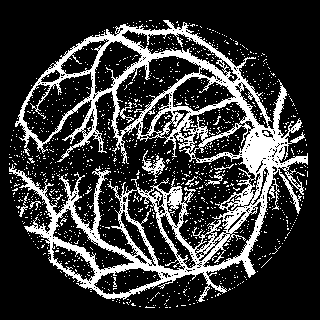

In [ ]:
images = glob.glob('DRIVE/training/images/*')
images = images[:1]
nof = 5
xTrain = np.zeros((len(images) * 320 * 320, nof), dtype = 'float32')
yTrain = np.zeros((len(images) * 320 * 320, 1), dtype = 'int32')
count0 = 0
count1=0
count=0
for i in images:
  print(count)
  img = cv2.imread(i)
  img=cv2.resize(img,(320,320))
  l=320*320
  cv2_imshow(img)
  img = img[:, :, 1]
  img=img.astype('float32')
  sX = convolution(img, sobelX)
  sY = convolution(img, sobelY)
  pX = convolution(img, prewittX)
  pY = convolution(img, prewittY)
  x1 = (np.absolute(sX) + np.absolute(sY))
  x8 = (np.absolute(pX) + np.absolute(pY))
  x2 = convolution(img, laplacian)
  x3 = convolution(img, LOG)
  blurred_image = gaussian_blur(img, kernel_size=3, verbose=False)
  edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter, convert_to_degree=True)
  new_image = non_max_suppression(gradient_magnitude, gradient_direction)
  weak = 50
  new_image = threshold(new_image, 5, 20, weak=weak)
  x4 = hysteresis(new_image, weak)
  x5=np.zeros(img.shape)
  x6=np.zeros(img.shape)
  x7=np.zeros(img.shape)
  element = np.ones((5,5))
  o1=cv2.morphologyEx(img, cv2.MORPH_TOPHAT, element)
  o2=cv2.dilate(img, element, iterations=1)
  o3=cv2.erode(img, element, iterations=1)
  x5=np.add(x5,o1)
  x6 = np.add(x6,o2)
  x7 = np.add(x7,o3)
  img_name = images[0].split('/')[-1].split('_')[0]x
  cap = cv2.VideoCapture('DRIVE/training/1st_manual/' + img_name + '_manual1.gif')
  ret, y = cap.read()
  cap = cv2.VideoCapture('DRIVE/training/mask/' + img_name + '_training_mask.gif')
  ret, mask = cap.read()
  mask = cv2.resize(mask, (320, 320))
  mask = mask[:, :, 1].reshape((l, 1))
  y=cv2.resize(y,(320,320))
  y = y[:, :, 1].reshape((l,))
  x1 = x1.reshape((l,))
  x3 = x3.reshape((l,))
  x4 = x4.reshape((l,))
  x7 = x7.reshape((l,))
  x8 = x8.reshape((l,))

  for j in range(l):
    if mask[j] != 0:
      xTrain[j + count * l][0] = x1[j]
      xTrain[j + count * l][1] = x3[j]
      xTrain[j + count * l][2] = x4[j]
      xTrain[j + count * l][3] = x7[j]
      xTrain[j + count * l][4] = x8[j]
      if y[j] > 1:
        count1+=1
        yTrain[j + count * l] = 1
      else:
        yTrain[j + count * l] = -1
        count0+=1
  count += 1

In [ ]:
count = 0
c0 = 0
c1 = 0
x_train = np.zeros((2*(count1), nof))
y_train = np.zeros((2*(count1)), dtype = 'int')
for i in range(len(yTrain)):
  if yTrain[i] == -1 and c0 != count1:
    y_train[count] = 0
    x_train[count] = xTrain[i]
    c0 += 1
    count += 1
  elif yTrain[i] == 1 and c1 != count1:
    y_train[count] = 1
    x_train[count] = xTrain[i]
    c1 += 1
    count += 1

In [ ]:
c0

65490

In [ ]:
c1

65490

In [ ]:
train_Y_one_hot = to_categorical(y_train)

In [ ]:
train_Y_one_hot[0]

array([1., 0.], dtype=float32)

In [ ]:
y_train.shape

(130980,)

## **Modeling**

In [6]:
# Defining the model
input = Input(shape = (nof,))
h1 = Dense(8, activation='tanh')(input)
ha1 = concatenate([input, h1])
h2 = Dense(10, activation='tanh')(ha1)
ha2 = concatenate([input, h1, h2])
h3 = Dense(10, activation='sigmoid')(ha2)
ha3 = concatenate([input, h1, h2, h3])
h4 = Dense(10, activation='tanh')(ha3)
ha4 = concatenate([input, h1, h2, h3, h4])
output = Dense(2, activation='softmax')(h4)

In [7]:
model = Model(input, output)

In [8]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
model.compile(optimizer='adam', loss= 'categorical_crossentropy',metrics=METRICS)

In [ ]:
hist = model.fit(x_train, train_Y_one_hot, epochs = 30, batch_size = 16, verbose = 1)

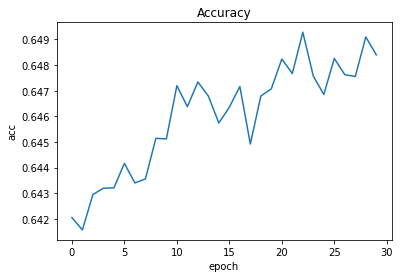

In [ ]:
plt.plot(hist.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(hist.history['auc'])
plt.title('ROC curve')
plt.ylabel(hist.history)
plt.xlabel('epoch')
plt.show()

### **Testing**

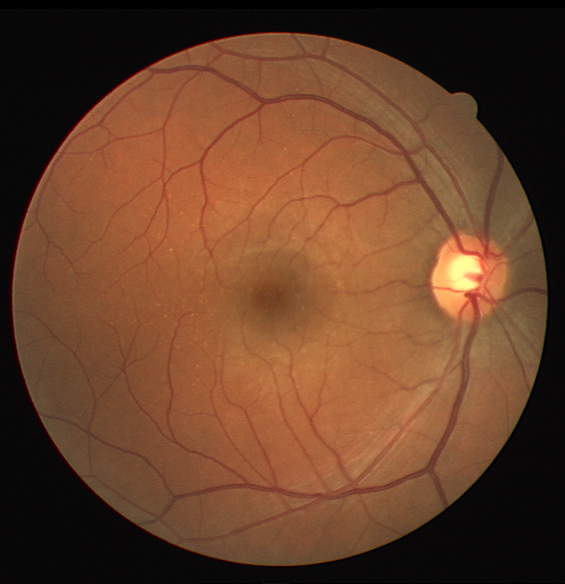

Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)
Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)
Image Shape : (320, 320)
Kernel Shape : (3, 3)
Output Image size : (320, 320)


In [ ]:
# Testing phase
images = glob.glob('DRIVE/training/images/*')
test = cv2.imread(images[13])
cv2_imshow(test)
test = cv2.resize(test, (320, 320))
x10 = test[:, :, 2]
img = test[:, :, 1]
sX = convolution(img, sobelX)
sY = convolution(img, sobelY)
pX = convolution(img, prewittX)
pY = convolution(img, prewittY)
x1 = (np.absolute(sX) + np.absolute(sY))
x8 = (np.absolute(pX) + np.absolute(pY))
# x2=(np.absolute(rX) + np.absolute(rY))
x3 = convolution(img, LOG)
blurred_image = gaussian_blur(img, kernel_size=3, verbose=False)
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) 
gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter, convert_to_degree=True)
new_image = non_max_suppression(gradient_magnitude, gradient_direction)
weak = 50
new_image = threshold(new_image, 5, 20, weak=weak)
x4 = hysteresis(new_image, weak)
x5=np.zeros(img.shape)
x6=np.zeros(img.shape)
x7=np.zeros(img.shape)
element = np.ones((5,5))
o1=cv2.morphologyEx(img, cv2.MORPH_TOPHAT, element)
o2=cv2.dilate(img, element, iterations=1)
o3=cv2.erode(img, element, iterations=1)
x5=np.add(x5,o1)
x6 = np.add(x6,o2)
x7 = np.add(x7,o3)

In [ ]:
x1 = x1.reshape((l, 1))
# x2 = x2.reshape((l, 1))
x3 = x3.reshape((l, 1))
x4 = x4.reshape((l, 1))
x5 = x5.reshape((l, 1))
x6 = x5.reshape((l, 1))
x7 = x7.reshape((l, 1))
x8 = x8.reshape((l, 1))
x10 = x10.reshape((l, 1))
x = np.zeros((l, nof))
y = np.zeros((l, 1))
for i in range(l):
  x[i][0] = x1[i]
  x[i][1] = x3[i]
  x[i][2] = x4[i]
  x[i][3] = x7[i]
  x[i][4] = x8[i]

In [ ]:
t = model.predict(x)
print(t.shape)

(102400, 2)

In [ ]:
count = 0
for i in t:
  if i[0] > i[1]:
    y[count] = 0
  else:
    y[count] = 255
  count += 1

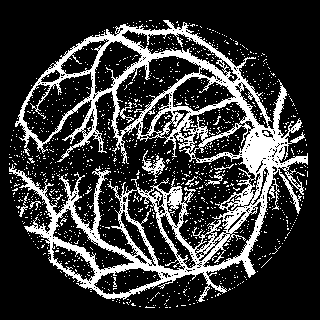

In [ ]:
y = y.reshape((320, 320, 1))
cv2_imshow(y)